In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import pandahouse as ph

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Объявляем параметры подключения
connection_default = {'host': '************************',
                      'database':'*********************',
                      'user':'*************************', 
                      'password':'*********************'
                     }

## Задания:


#### 1. Проверим правильность подключения к ClickHouse через pandahouse, отправив простой запрос: выведите количество строк в таблице ldn_listings.

In [3]:
# Напишем запрос к ClickHouse
query = """
SELECT COUNT(*)
FROM ldn_listings
"""

In [4]:
# Выполним запрос
ph.execute(query, connection=connection_default).strip()

b'85207'

#### 2. Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:
- **price** – цена за ночь
- **room_type** – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

#### Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id. Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены для комнат типа Private room.

In [5]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_2 = """
SELECT
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    room_type
FROM ldn_listings
ORDER BY id
LIMIT 1000
"""

In [6]:
# Считаем данные и отобразим первые пять сток
df2 = ph.read_clickhouse(query_2, connection=connection_default)
df2.head()

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt


In [7]:
# Посчитаем 75-й перцентиль
df2.groupby('room_type').price.quantile(q=0.75).to_frame()[2:3].reset_index()

,room_type,price
0,Private room,70.0


#### 3. К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

#### Давайте построим график рассеивания, который покажет зависимость средней цены от средней оценки в зависимости от типа жилья.

In [8]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_3 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
    toFloat32OrNull(review_scores_rating) AS review_rating
FROM ldn_listings
WHERE review_rating > 0
"""

In [9]:
# Считаем данные и отобразим первые пять сток
df3 = ph.read_clickhouse(query_3, connection=connection_default)
df3.head()

,room_type,price,review_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0


In [10]:
# Сгруппируем данные по типу комнат и посчитаем среднее значение
room_type_mean = df3 \
                    .groupby('room_type', as_index=False) \
                    .agg({'price': 'mean', 'review_rating': 'mean'})


<AxesSubplot:xlabel='price', ylabel='review_rating'>

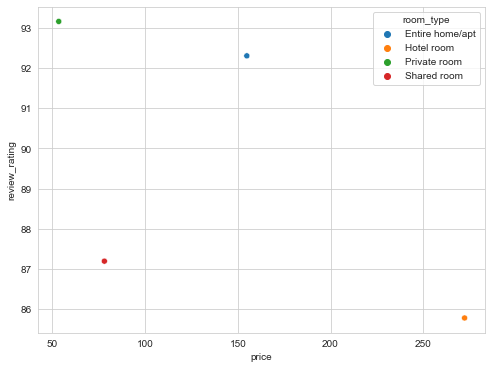

In [11]:
# Построим график рассеивания
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='review_rating', hue='room_type', data=room_type_mean)

#### 4. Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

- host_id – идентификатор хозяина (уникальный)
- host_verifications – какими способами хост подтвердил свой профиль

**В ячейках находятся строковые представления списка. Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта.**

**Сколько хозяев подтвердили профиль с помощью аккаунта Google?**

In [12]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_4 = """
SELECT
    DISTINCT(host_id),
    host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'
"""

In [13]:
# Считаем данные и отобразим первые пять сток
df4 = ph.read_clickhouse(query_4, connection=connection_default)
df4.head()

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."


In [14]:
# Преобразуем строковый тип в host_verifications к списку
df4['host_verifications'] = df4.host_verifications.str.findall('([A-Za-z]+)')
df4.head()

,host_id,host_verifications
0,54730,"[email, phone, facebook, reviews, offline, gov..."
1,60302,"[email, phone, reviews, jumio, government, id]"
2,67915,"[email, phone, jumio, selfie, government, id, ..."
3,167107,"[email, phone, manual, offline, jumio, offline..."
4,103583,"[email, phone, reviews, offline, government, i..."


In [15]:
# Преобразуем списки в колонке в отдельные ряды и посчитаем значения и выделим нужный тип верификации
google = df4.explode('host_verifications').host_verifications.value_counts()['google']
print(f'Количество подтверждений профиля с помощью аккаунта Google - {google}.')

Количество подтверждений профиля с помощью аккаунта Google - 34.


#### 5. Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

#### Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

In [16]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_5 = """
SELECT
    neighbourhood_cleansed,
    experiences_offered,
    count(experiences_offered) AS experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
GROUP BY neighbourhood_cleansed, experiences_offered
ORDER BY experiences_count DESC
LIMIT 100
"""

In [17]:
# Считаем данные и отобразим первые пять сток
df5 = ph.read_clickhouse(query_5, connection=connection_default)
df5.head()

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48


In [18]:
# Преобразуем данные с помощью pivot_table и отобразим первые 5 строк
table = pd.pivot_table(data=df5, index='neighbourhood_cleansed', columns='experiences_offered',
                       values='experiences_count', fill_value=0)
table.head()

experiences_offered,business,family,romantic,social
neighbourhood_cleansed,,,,
Barking and Dagenham,0,0,0,2
Barnet,7,7,3,5
Bexley,1,0,0,0
Brent,9,21,5,6
Bromley,3,2,0,4


<AxesSubplot:xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

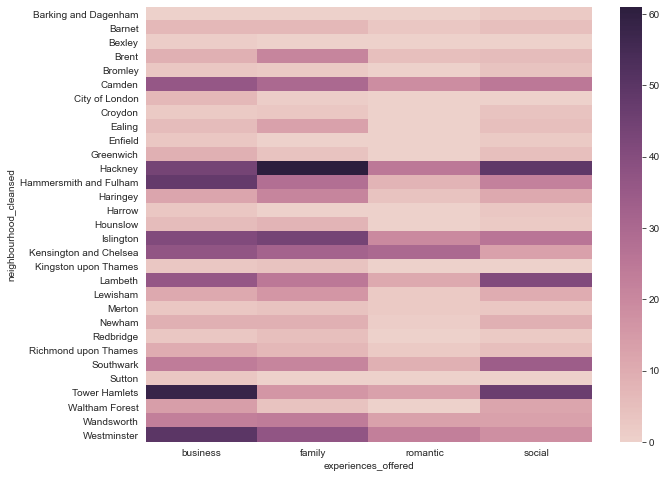

In [19]:
# Визуализируем данные с применением требуемых параметров
plt.figure(figsize=(10, 8))
sns.heatmap(table, cmap=sns.cubehelix_palette(as_cmap=True))

#### 6. Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

- **room_type** – тип сдаваемого жилья
- **price** – цена за ночь 
- **experiences_offered** – вид доступного впечатления

#### Далее постройте два графика, используя distplot из библиотеки seaborn:
- **На первом отобразите исходные распределения цен для каждого типа жилья**
- **На втором – логарифмированные значения**

In [20]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_6 = """
SELECT
    room_type,
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
FROM ldn_listings
WHERE experiences_offered != 'none'
"""

In [21]:
# Считаем данные, добавим столбец с логорифмом цены и отобразим первые пять сток
df6 = ph.read_clickhouse(query_6, connection=connection_default)
df6['log_price'] = np.log(df6.price)
df6.head()

,room_type,price,log_price
0,Private room,65.0,4.174387
1,Entire home/apt,100.0,4.605170
2,Private room,150.0,5.010635
3,Private room,45.0,3.806663
4,Private room,25.0,3.218876


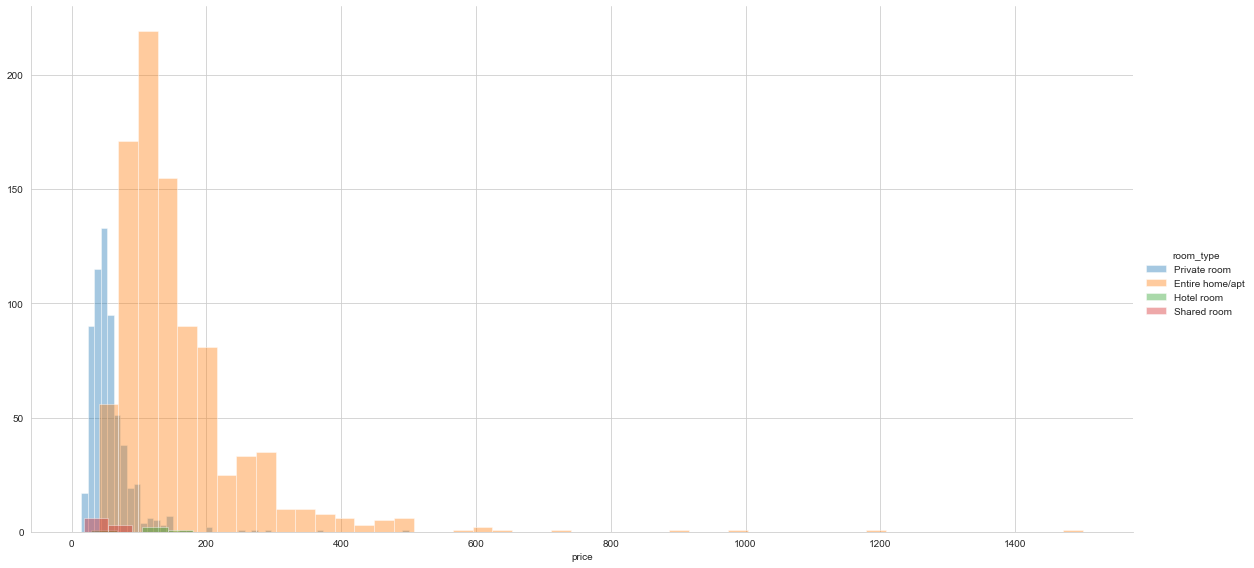

In [22]:
g = sns.FacetGrid(df6, hue='room_type', height=8, aspect=2)
g.map(sns.distplot, 'price', kde=False)
g.add_legend();

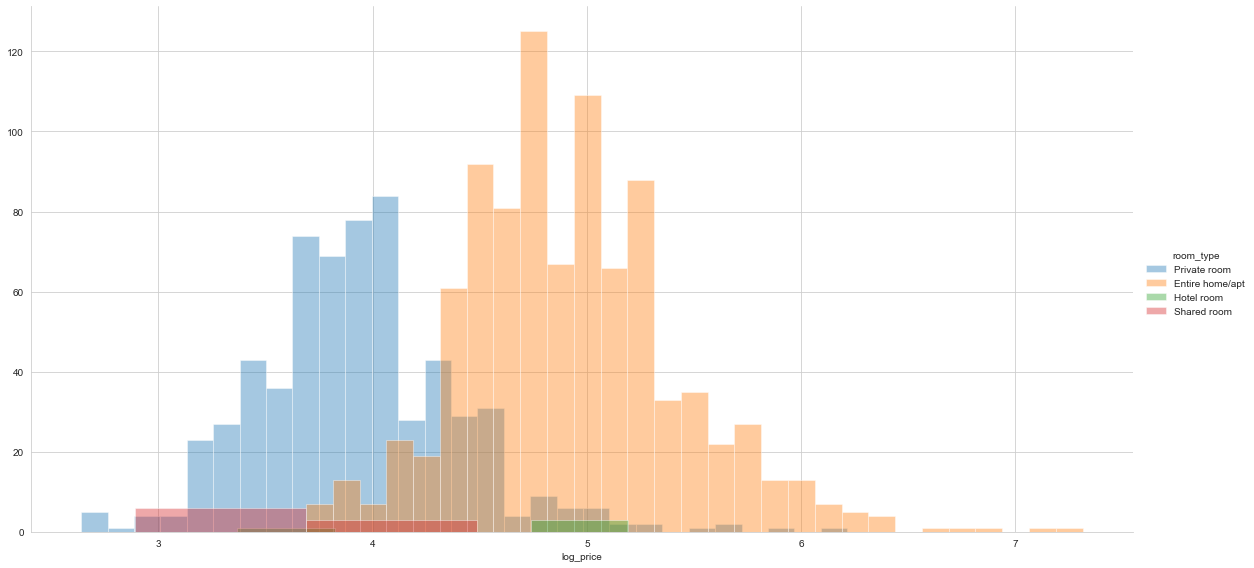

In [23]:
g = sns.FacetGrid(df6, hue='room_type', height=8, aspect=2)
g.map(sns.distplot, 'log_price', kde=False)
g.add_legend();

#### 7. Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

- **room_type** – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
- **price** – цена за ночь
- **first_review** – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")

**Ограничение поставьте на 1000 строк.**

#### Используя библиотеку seaborn, постройте график динамики средних цен на жилье в зависимости от типа комнаты по годам. Датафрейм должен быть отсортирован по годам.

In [24]:
# Напишем запрос к ClickHouse и отберем необходимые данные
query_7 = """
SELECT
    room_type,
    round(avg(price), 2) AS avg_price,
    review_year AS year
FROM (
        SELECT
            room_type,
            toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
            toDateOrNull(first_review) AS first_review,
            toYear(first_review) AS review_year
        FROM ldn_listings
        WHERE first_review > '2010-01-01'
        LIMIT 1000
     )
GROUP BY room_type, review_year
ORDER BY review_year
"""

In [25]:
# Считаем данные и отобразим первые пять сток
df7 = ph.read_clickhouse(query_7, connection=connection_default)
df7.head()

,room_type,avg_price,year
0,Entire home/apt,103.50,2010
1,Hotel room,88.00,2010
2,Private room,56.43,2010
3,Private room,52.61,2011
4,Entire home/apt,128.79,2011


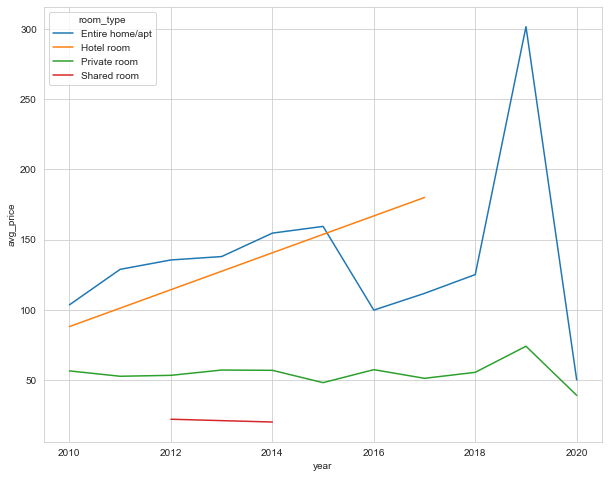

In [26]:
# Построим график
plt.figure(figsize=(10, 8))
sns.lineplot(x='year', y='avg_price', data=df7, hue='room_type');